In [40]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from datetime import datetime
from pandas.io.json import json_normalize
import seaborn as sns

In [41]:
import warnings
warnings.filterwarnings('ignore')
#use 'default' to show warnings and 'ignore' to hide warnings

In [ ]:
with open('/Users/Work/Desktop/Springboard/data/yelp_dataset_challenge_academic_dataset/\
yelp_academic_dataset_business.json', 'rb') as f:
    data = f.readlines()
data_json_str = "[" + ','.join(data) + "]"
df = pd.read_json(data_json_str)

In [ ]:
data_json_str

In [248]:
starbucks=df[df.name.str.contains('Starbucks')]

In [5]:
import pickle
o = open('/Users/Work/Desktop/Springboard/data/yelp_dataset_challenge_academic_dataset/\
reviews_pickle.pkl','r')
reviews=pickle.load(o) 
o.close()

In [6]:
df2=pd.DataFrame(reviews)

In [51]:
starbucks.columns

Index([u'attributes', u'business_id', u'categories', u'city', u'full_address',
       u'hours', u'latitude', u'longitude', u'name', u'neighborhoods', u'open',
       u'review_count', u'stars', u'state', u'type'],
      dtype='object')

In [7]:
df.columns

Index([u'attributes', u'business_id', u'categories', u'city', u'full_address',
       u'hours', u'latitude', u'longitude', u'name', u'neighborhoods', u'open',
       u'review_count', u'stars', u'state', u'type'],
      dtype='object')

Cohen's d is a measurement of the difference between two means.  A greater Cohen's d value would suggest that the two means are different.  It is computed as the difference between the two means standardized by dividing by the standard deviation.  In this particular formula, the standard deviation is calculated as the pooled standard deviation.  Thus a Cohen's d of 1, which is typically considered as large (via http://www.polyu.edu.hk/mm/effectsizefaqs/calculator/result.html), is read as the two means differing by 1 pooled standard deviation.  The following code is provided on Allen Downey's GitHub.  

In [253]:
def CohenEffectSize(group1, group2):
    """Compute Cohen's d.

    group1: Series or NumPy array
    group2: Series or NumPy array

    returns: float
    """
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    d = diff / np.sqrt(pooled_var)
    return d

## Taking a look at the number of reviews for each starbucks location

In [59]:
df2.groupby('business_id').size().describe()[['mean','50%','max']]

mean    17.163968
50%     13.000000
max     91.000000
dtype: float64

The average number of reviews for a location is 17, while the median is only 13.  Some stores with a large number of reviews, like the store with 91 reviews, are pulling the mean above the median.  

The below is a histogram showing the number of reviews on the x axis and the number of starbucks stores on the y axis.

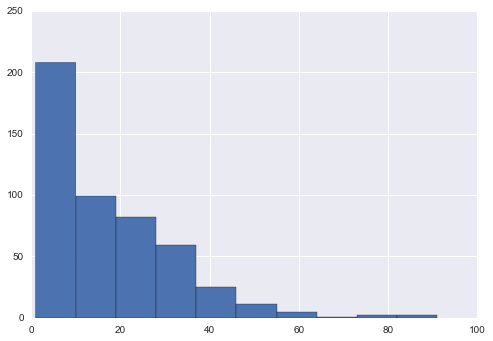

In [123]:
df2.groupby('business_id').size().hist()

The distribution of reviews is skewed right in that most stores have 13 or less reviews, though some have a very high number of reviews.

The top 5 starbucks stores with the most number of reviews are as follows:

In [927]:
most_reviews=df2.groupby('business_id').size().sort_values(ascending=False)
most_reviews.head(5)

business_id
yXMvhCmUADlaHabo-DiUYw    91
P25sdf5qPh-FlN_ar1EXhw    86
yIv8VEboEvZDslF1pr6S9g    79
Hs_N9FLF8RDCe0tHiZKXhw    77
0cvZUir2H5BnzRD6v0riBg    69
dtype: int64

The top 10 starbucks stores with the most number of reviews are located in the following cities:

In [915]:
starbucks[starbucks.business_id.isin(list(most_reviews.head(10).index.values))]\
.groupby(['city','state']).size().sort_values(ascending=False)

city       state
Las Vegas  NV       6
Henderson  NV       2
Phoenix    AZ       1
Charlotte  NC       1
dtype: int64

Do these stores have a lot of reviews due to the population of the region in which these stores reside or might there be some other reason?  Does review count have a positive correlation with population?  Below, I look up the cities of the 10 stores containing the most reviews.

### Investigating whether population correlates with review count

In [941]:
states = {
        'AK': 'Alaska','AL': 'Alabama','AR': 'Arkansas','AS': 'American Samoa','AZ': 'Arizona',
        'CA': 'California','CO': 'Colorado','CT': 'Connecticut','DC': 'District of Columbia',
        'DE': 'Delaware','FL': 'Florida','GA': 'Georgia','GU': 'Guam','HI': 'Hawaii',
        'IA': 'Iowa','ID': 'Idaho','IL': 'Illinois','IN': 'Indiana','KS': 'Kansas',
        'KY': 'Kentucky','LA': 'Louisiana','MA': 'Massachusetts','MD': 'Maryland','ME': 'Maine',
        'MI': 'Michigan','MN': 'Minnesota','MO': 'Missouri','MP': 'Northern Mariana Islands',
        'MS': 'Mississippi','MT': 'Montana','NA': 'National','NC': 'North Carolina',
        'ND': 'North Dakota','NE': 'Nebraska','NH': 'New Hampshire','NJ': 'New Jersey',
        'NM': 'New Mexico','NV': 'Nevada','NY': 'New York','OH': 'Ohio','OK': 'Oklahoma',
        'OR': 'Oregon','PA': 'Pennsylvania','PR': 'Puerto Rico','RI': 'Rhode Island',
        'SC': 'South Carolina','SD': 'South Dakota','TN': 'Tennessee','TX': 'Texas',
        'UT': 'Utah','VA': 'Virginia','VI': 'Virgin Islands','VT': 'Vermont',
        'WA': 'Washington','WI': 'Wisconsin','WV': 'West Virginia','WY': 'Wyoming'}

In [942]:
states = dict((v,k) for k,v in states.iteritems())

In [36]:
#data source: http://www.census.gov/popest/data/cities/totals/2015/SUB-EST2015.html
city_pop = pd.read_csv('/Users/Work/Desktop/Springboard/Data/\
yelp_dataset_challenge_academic_dataset/city_populations.csv')

In [929]:
most_reviews=df2.groupby('business_id').size().sort_values(ascending=False).head(2000)
most_reviews_cities=starbucks[starbucks.business_id.isin(list(most_reviews.index.values))]\
[['business_id','city','state']]
most_reviews_cities['city2']=most_reviews_cities.city.map(lambda x: x+' city')
most_reviews_cities['citystate']=zip(most_reviews_cities['city2'],most_reviews_cities['state'])
most_reviews_cities['population']=''

In [931]:
temp=list(most_reviews_cities.city2.unique())
temp2=list(most_reviews_cities.citystate.unique())
city_pop_subset=city_pop[city_pop.NAME.isin(temp)]

Below, I create a column in city_pop_subset consisting of tuples containing the city and state of the record, which I'll use to join the two tables (city_pop_subset and most_reviews_cities) to fill in the population values in the most_reviews_cities table.  I did this because some city names have multiple state values associated with them, so I don't want to put the wrong population value for a given (city, state) tuple in most_reviews_cities.

In [932]:
city_pop_subset['state2']=''
temp3=[]
for j in range(len(city_pop_subset)):
    temp3.append(states[city_pop_subset.iloc[j].STNAME])
city_pop_subset['state2']=temp3
city_pop_subset['citystate']=zip(city_pop_subset.NAME,city_pop_subset.state2)

In [933]:
#Select only (city, state) tuples that are in most_reviews_cities
city_pop_subset=city_pop_subset[city_pop_subset.citystate.isin(temp2)]

In [934]:
city_pop_subset=city_pop_subset[['POPESTIMATE2015','state2','citystate']]
city_pop_subset.columns=['population','state','citystate']
city_pop_subset=city_pop_subset.drop_duplicates()

In [935]:
temp4=[]
for j in range(len(most_reviews_cities)):
    if most_reviews_cities.citystate.iloc[j] in list(city_pop_subset.citystate):
        for k in range(len(city_pop_subset)):
            if most_reviews_cities.iloc[j].citystate==city_pop_subset.iloc[k].citystate:
                temp4.append(city_pop_subset.iloc[k].population)
    else:
        temp4.append(0)
most_reviews_cities['population'] = temp4

In [968]:
most_reviews=df2.groupby('business_id').size().sort_values(ascending=False).head(2000)
most_reviews=pd.DataFrame(most_reviews,columns=['review_count'])
most_reviews=most_reviews.reset_index()
most_reviews=pd.merge(most_reviews_cities,most_reviews,on='business_id')

In [ ]:
avg_stars=df2.groupby('business_id').mean().stars
avg_stars=pd.DataFrame(avg_stars).reset_index()
avg_stars.columns=['business_id','avg_stars']
most_reviews=pd.merge(most_reviews,avg_stars,on='business_id')

### Scatterplot of population vs number of reviews

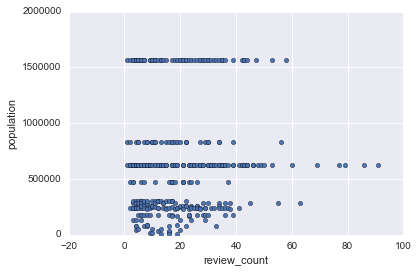

In [940]:
most_reviews[most_reviews.population!=0].sort_values('review_count')\
.plot(x='review_count',y='population',kind='scatter',ylim=[0,2000000],)

In [975]:
most_reviews.review_count.corr(most_reviews.population,method='spearman')

0.24700470636410374

The above scatterplot does not reveal much of a correlation between population and review count.  Many shops in the data appear to be located in cities.  The horizontal streams of dots for large populations exist because there are multiple shops in the same city with differing numbers of reviews.  Perhaps a correlation would be more apparent if the data had more shops located in smaller population towns and cities.  The correlation coefficient is .247, suggesting that the variables are only weakly positively correlated.

### Scatterplot of avg stars vs number of reviews

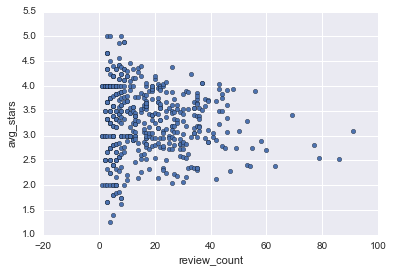

In [971]:
most_reviews.sort_values('review_count')\
.plot(x='review_count',y='avg_stars',kind='scatter')

In [977]:
most_reviews.review_count.corr(most_reviews.avg_stars,method='spearman')

-0.10942087950137543

While the correlation coefficient is only -.109, the scatterplot does show a rather obvious negative correlation.  Also, the variance of the average stars for a given review count appears to decrease as review count increases.  

## Investigating Starbucks stores that have closed.

A closed store is indicated by the open field having a value of False.  
As shown below, there are 17 stores that have closed.

In [17]:
len(starbucks[starbucks.open==False])

17

Below, we see that most Starbucks locations that closed had 10 or less reviews.  

In [86]:
temp=list(starbucks[starbucks.open==False].business_id.values)
closed=df2[df2.business_id.isin(temp)]
s=df2[df2.business_id.isin(temp)].groupby('business_id').size().sort_values(ascending=False) 
list(s)

[27, 18, 14, 12, 11, 11, 10, 6, 5, 4, 4, 4, 4, 3, 3, 3, 1]

As shown below, the median number of reviews for all shops is greater than the median number of reviews for closed shops by 8, so closed shops received less reviews in general than open shops.  This makes sense because if a shop closes, reviews for that shop will not keep happening because there is no longer an open shop to review!

In [87]:
(df2.groupby('business_id').size().sort_values(ascending=False).describe()-s.describe())['50%']

8.0

Below, I take the difference between various descriptive statistics for the star scores of all Starbucks stores and closed Starbucks stores.  The first quartile of closed shops is one star lower than that of all shops.  25% of closed shops received 2 stars or less, while 25% of all shops received 3 stars or less.  This might give evidence to the idea that these shops are now closed because of having difficulties that were reflected in their yelp scores, meaning yelp starbucks stars can predict the success of a location.  

Cohen's d is very low, suggesting that the mean stars of closed stores and the mean stars of all stores are not very different.

In [256]:
CohenEffectSize(closed.stars.values, starbucks.stars.values)

-0.050685671434620071

In [89]:
(starbucks.stars.describe()-closed.stars.describe())['25%']

1.0

In [70]:
closed.stars.describe()['25%']

2.0

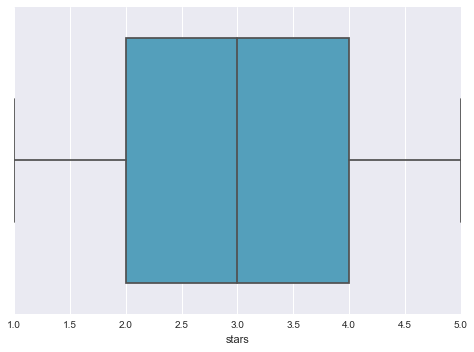

In [60]:
sns.boxplot(closed.stars,palette='GnBu_d')

### Boxplot of the Starbucks star distribution

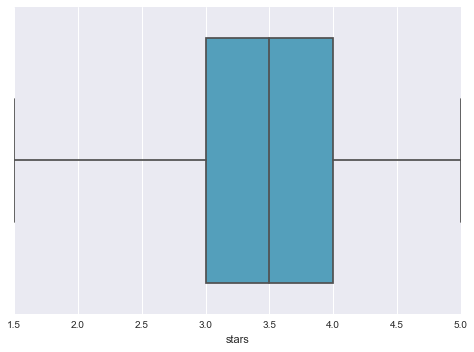

In [122]:
sns.boxplot(starbucks.stars,palette='GnBu_d')

The median number of stars is 3.5.   
75% of stores have 4 stars or less.  
25% of stores have 3 stars or less.

### Histogram of Starbucks star ratings

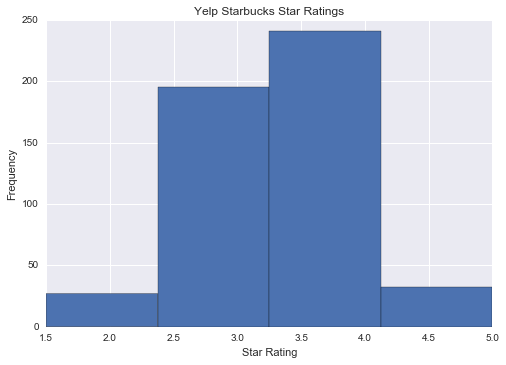

In [127]:
fig, axes = plt.subplots(1,1,dpi=200)
axes.hist(starbucks.stars,bins=4)
axes.set_title('Yelp Starbucks Star Ratings')
axes.set_xlabel('Star Rating')
axes.set_ylabel('Frequency')

## Investigating the relationship between review date and stars

In [979]:
df2.date=pd.to_datetime(df2.date)

Or we could have done the following to convert date to datetime:
temp=[]
for j in range(len(df2)):
    temp.append(datetime.strptime(df2.date[j], '%Y-%m-%d'))
df2['date']=temp

In [980]:
temp=[]
for j in range(len(df2)):
    temp.append(df2.date[j].year)
df2['year']=temp

Below, we see that the data starts becoming credible around 2010, when the number of reviews hits the triple digits.

In [981]:
df2.groupby('year').size()

year
2005       1
2006       4
2007      20
2008      58
2009      95
2010     328
2011     792
2012     882
2013    1360
2014    2146
2015    2793
dtype: int64

We see below that starting in 2010, the average number of stars for a given location decreases from year to year.  Perhaps this has to do with the fact that there are more reviews each subsequent year.

In [202]:
df2[df2.year>=2008].groupby('year').mean()

,stars
year,
2008,3.362069
2009,3.357895
2010,3.612805
2011,3.599747
2012,3.547619
2013,3.435294
2014,3.106244
2015,2.969925


The line plot below shows that the average number of stars as a function of years is concave downward.  The rate of change of the avg stars decreases as year increases.  

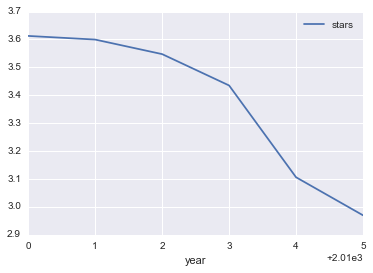

In [1117]:
df2[df2.year>=2010].groupby('year').mean().plot()

The line plot below shows that the median number of stars as a function of years decreases more sharply than the mean.  The median is 4 stars from 2010 to 2013 and then decreases to 3 stars in 2014 and 2015.   

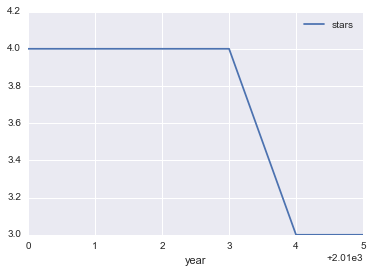

In [1118]:
df2[df2.year>=2010].groupby('year').median().plot()

Below, we see that the average number of stars in the last two years is being pulled down by a greater frequency of reviews with 2 stars or lower.  25% of reviews in 2014 had 2 stars or less.  25% of reviews in 2015 had 1 stars or less.  Before 2014, 25% of reviews had 3 stars or less every year.  

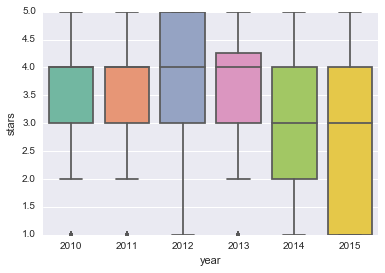

In [982]:
sns.boxplot(x=df2[df2.year>=2010].year,y=df2.stars,palette='Set2')

What happened in 2015?  Star scores seem to have taken a nose dive.  The histogram below shows the distribution of stars for 2015.  There were 800 reviews in which the user gave Starbucks just 1 star.  The high frequency of 1 star reviews has pulled the first quartile of the interquartile range down to 1 star.  

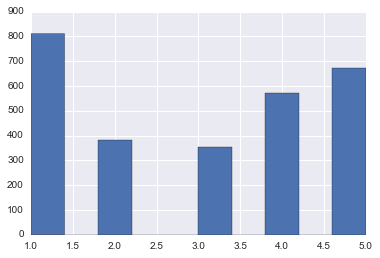

In [996]:
df2[df2.date.dt.year==2015].stars.hist()

In [1037]:
avg_stars_2015=df2[(df2.date.dt.year==2015)].groupby('business_id').mean()
avg_stars_2015=pd.DataFrame(avg_stars_2015).reset_index()
avg_stars_2015=pd.merge(avg_stars_2015,most_reviews[['business_id','review_count']]\
,on='business_id')

Below, I see whether removing stores with many reviews and having a low average star score changes the interquartile range (aka whether the removal of stores that are outliers has an effect).  I classify outliers as having a star score less than or equal to 2 and a review count of at least 30 reviews, so the store needs a low score and a large number of reviews.

In [1116]:
outliers_df=avg_stars_2015[(avg_stars_2015.stars<=2) & (avg_stars_2015.review_count > 30)]\
.sort_values('stars',ascending=True)
outliers_df.head()

,business_id,stars,year,review_count
334,ieheWXxYPTM2stGLV7fEPw,1.583333,2015.0,42
52,5Q49MxuWJgXS649i7i2Iow,1.600000,2015.0,53
98,BAKRDK_sZk-B06jKWz9hVg,1.611111,2015.0,34
376,pPbAvdjmTkMaEXVJyPGIug,1.636364,2015.0,35
106,CK6Vf3ii1Hj-4AlgbS6NJQ,1.666667,2015.0,41


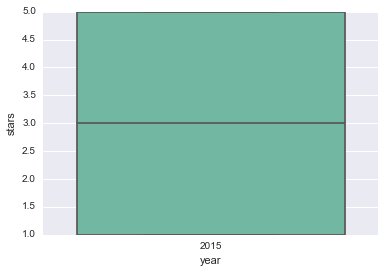

In [1113]:
stars_2015=df2[df2.year==2015]
outliers=list(outliers_df.business_id.values)
stars_2015=stars_2015[~stars_2015.business_id.isin(outliers)]
sns.boxplot(x=stars_2015[stars_2015.year==2015].year,y=stars_2015.stars,palette='Set2')

From the above boxplot, the first quartile is still 1 star, meaning there are still a large number of reviews with 1 star.  However, the third quartile has shifted to 5 stars, rather than 4 stars, meaning 75% of all reviews have 5 stars or less if we exclude stores classified as outliers.  

## Investigating whether stars vary by region and state

In [272]:
Northeast=['CT','ME','MA','NH','RI','VT','NJ','NY','PA']
Midwest=['IL','IN','MI','OH','WI','IA','KS','MN','MO','NE','ND','SD']
South=['DE','DC','FL','GA','MD','NC','SC','VA','WV']
West=['AZ','CO','ID','MT','NV','NM','UT','WY','AK','CA','HI','OR','WA']
Canada=['EDH','BW','ON','QC']

In [273]:
temp=[]
for x in range(len(starbucks)):
    if starbucks['state'].iloc[x] in Northeast:
        temp.append('Northeast')
    elif starbucks['state'].iloc[x] in Midwest:
        temp.append('Midwest')
    elif starbucks['state'].iloc[x] in South:
        temp.append('South')
    elif starbucks['state'].iloc[x] in West:
        temp.append('West')
    elif starbucks['state'].iloc[x] in Canada:
        temp.append('Canada')
    else:
        temp.append('NA')
starbucks['region']=temp

We see below that most Starbucks locations in the Yelp data are in Arizona and Nevada.  We observe that the data contains locations in Canada.  Most importantly, we observe that the data does not include every Starbucks.  Entire states are missing from the data.  

In [274]:
starbucks.groupby(['state','region']).size().sort_values(ascending=False)

state  region   
AZ     West         201
NV     West         161
NC     South         41
QC     Canada        26
PA     Northeast     24
EDH    Canada        20
WI     Midwest       10
ON     Canada         6
IL     Midwest        3
BW     Canada         2
SC     South          1
dtype: int64

In [94]:
df[df.name.str.contains('Starbucks')].groupby('state').size()

state
AZ     201
BW       2
EDH     20
IL       3
NC      41
NV     161
ON       6
PA      24
QC      26
SC       1
WI      10
dtype: int64

### Boxplot of stars by region

Canada and the Northeast region have a higher interquartile range of 3.5 to 4 stars, unlike other regions, which have an interquartile range of 3 to 3.5 stars.  

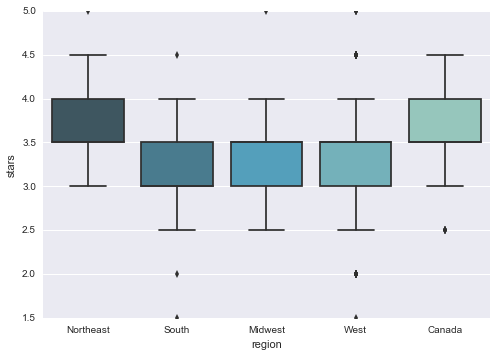

In [16]:
sns.boxplot(starbucks.stars,groupby=starbucks.region,palette='GnBu_d')

### Cohen's d as a measurement of the effect size

In [277]:
CohenEffectSize(starbucks[starbucks.region=='Northeast'].stars.values,\
                starbucks[starbucks.region=='South'].stars.values)

1.0288927269766084

### Boxplot of stars by state

The boxplot below suggests that the distribution of star scores varies by state.  PA has the highest interquartile range (3.5 to 4 stars), while Illnois has one of the lowest interquartile ranges (2.5 to 3.25 stars).  

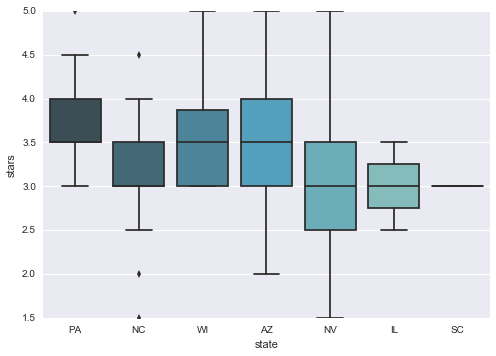

In [35]:
drop_canada=starbucks[starbucks.region!='Canada']
sns.boxplot(drop_canada.stars,groupby=drop_canada.state,palette='GnBu_d')

## Below, we compare boxplots for starbucks stores having specific words in their reviews and stores NOT having these words

### Review content containing the words 'dirty' or 'filthy', suggesting an unclean store

Below, we investigate differences in the star score distribution for locations with the words 'dirty' or 'filthy'
in their review content vs locations excluding these words.  Reviews containing these two words would suggest that guests regard the store as not clean.  

The boxplots below show that stores regarded as not clean (as measured by having the words 'dirty' or 'filthy' in their review content) have a smaller third quartile that equals 3.5 stars, meaning 75% of unclean stores have a star score of 3.5 or less.  Stores regarded as clean have a third quartile of 4.5 stars, meaning 75% of stars are less than 4.5 stars.  This difference suggests that stores regarded as unclean tend to have lower yelp scores.  

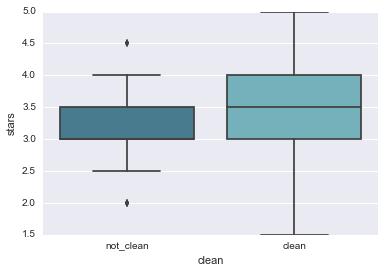

In [1145]:
clean=df2[(df2.text.str.contains('dirty')) | (df2.text.str.contains('filthy')) |
          (df2.text.str.contains('messy'))].business_id.unique()
starbucks['clean'] = starbucks['business_id'].map( lambda x: 'not_clean' if x in list(list(clean)) else 'clean')
sns.boxplot(y=starbucks.stars,x=starbucks['clean'],palette='GnBu_d',orient=False)

### Review content containing the word 'homeless', suggesting a homeless person problem

The boxplots below show that Starbucks locations with the word 'homeless' in their text reviews have a third quartile of 3.5 stars while locations without the word 'homeless' have a third quartile of 4.5 stars.  This difference suggests that stores with homeless people in or around them tend to have lower yelp scores.  

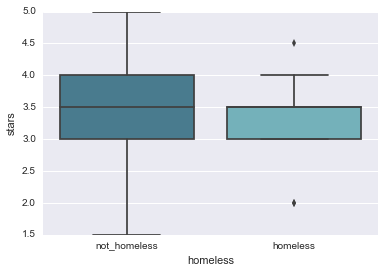

In [1144]:
homeless=df2[df2.text.str.contains('homeless')].business_id.unique()
starbucks['homeless'] = starbucks['business_id'].map( lambda x: 'homeless' if x in list(list(homeless)) else 'not_homeless')
sns.boxplot(y=starbucks.stars,x=starbucks['homeless'],palette='GnBu_d',orient=False)

### Review content containing the words 'mean' or 'rude', suggesting unfriendly baristas

The boxplots below show that Starbucks locations with the words 'mean' or 'rude' in their text reviews have a third quartile of 3.5 stars while locations without these words have a third quartile of 4.5 stars.  This difference suggests that stores less friendly baristas tend to have lower yelp scores.  

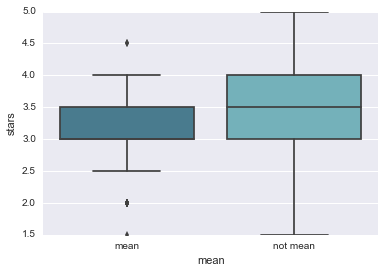

In [1143]:
mean_baristas=df2[df2.text.str.contains('rude',case=False) | (df2.text.str.contains('mean',case=False))].business_id
starbucks['mean'] = starbucks['business_id'].map( lambda x: 'mean' if x in list(list(mean_baristas)) else 'not mean')
sns.boxplot(y=starbucks.stars,x=starbucks['mean'],palette='GnBu_d',orient=False)